In [7]:
libraries = c("dplyr", "tidyverse", "magrittr", "scales", "ggplot2")
for(x in libraries) {library(x,character.only=TRUE,warn.conflicts=FALSE,quietly=TRUE)}

theme_set(theme_bw())

In [8]:
###0. data processing
#load data
raw_global_FoI_data <- read.csv("result_counter.csv")
raw_global_FoI_data$date <- as.Date(raw_global_FoI_data$date)
raw_global_FoI_data$date_import <- as.Date(raw_global_FoI_data$date_import)

global_FoI_data <- raw_global_FoI_data %>%
  filter(censoring==0)

vis_data <- global_FoI_data %>%
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom"))) %>%
#   filter(sub_region %in% c("Western Europe","Northern America"))
  filter(region %in% c("Europe"))
  #filter(location %in% c(selected_location2))#c(selected_location, sampled_location))



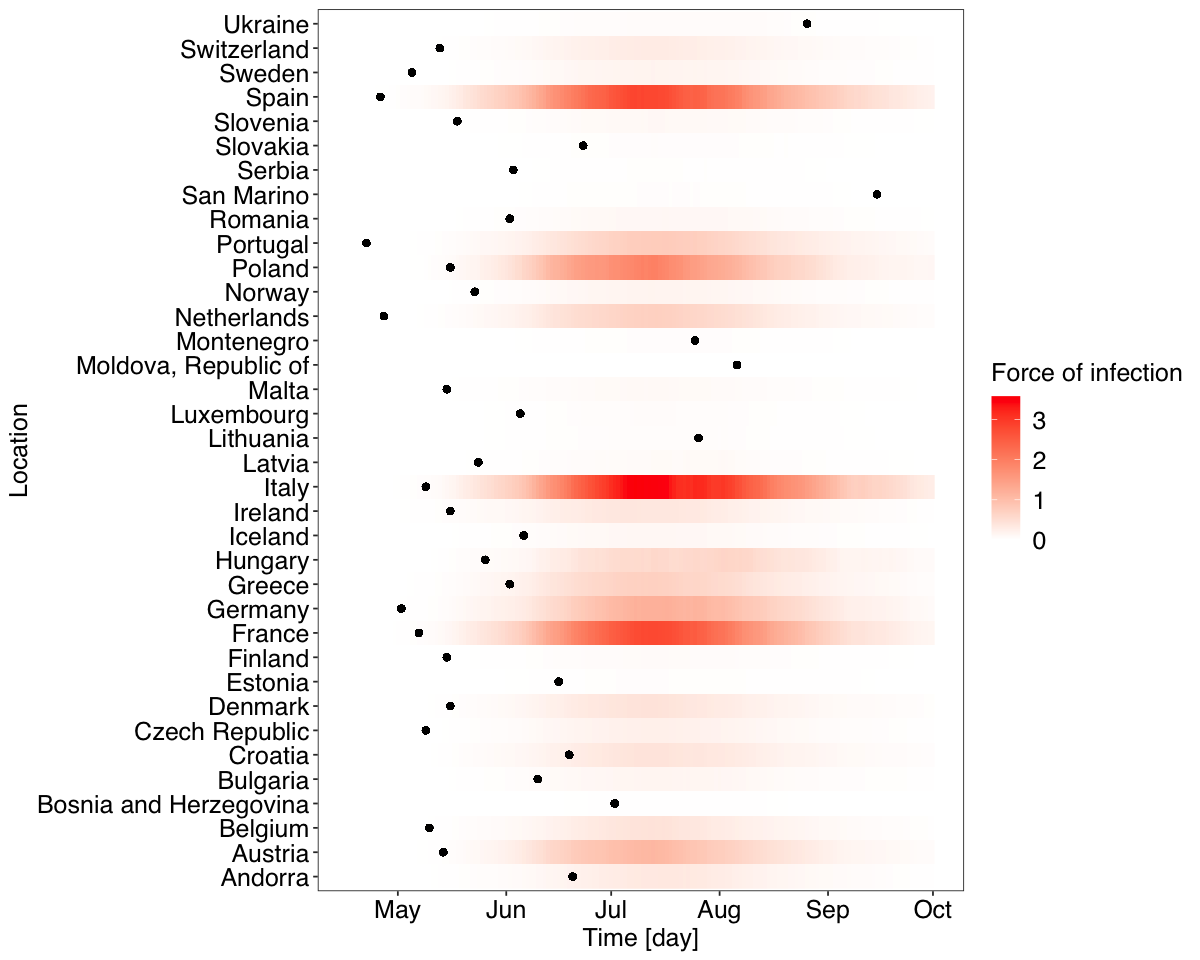

In [9]:
###1. FoI over time
theme_set(theme_bw())

options(repr.plot.width=10,repr.plot.height=8)
ggplot(data = vis_data,
       mapping = aes(x = date, y =location)) +
  geom_raster(aes(fill=h_i)) +
  scale_fill_gradient(low="white", high="red", name="Force of infection") +
  geom_point(mapping = aes(x=date_import, y=location))+#, color=region))+
  theme(text = element_text(size=15, family="sans",color="black"),
        axis.text = element_text(size=15, family="sans",color="black"),
        panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
        legend.title = element_text(size = 15),
        legend.text = element_text(size = 15),
        plot.title = element_text(size=18, family="sans",color="black")) +
  labs(x="Time [day]", y="Location")

ggsave("EU_FoI_counter.png", width = 10, height = 8)

Warning message:
“`position_stack()` requires non-overlapping x intervals”


[1] 0.446366

`summarise()` has grouped output by 'location'. You can override using the
`.groups` argument.


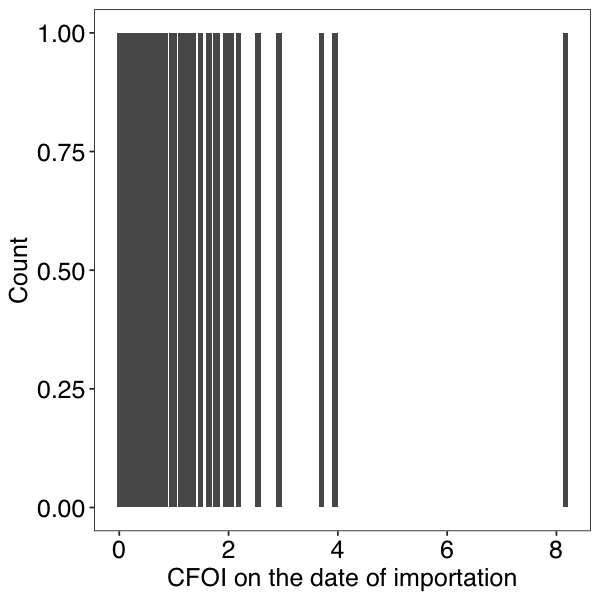

In [10]:
raw_global_FoI_data %>% filter(censoring==0) %>% dplyr::select(location, date, date_import, h_i) %>%
arrange(location, date) %>% group_by(location) %>% mutate(cum_h_i=cumsum(h_i)) %>% 
filter(!(location %in% c("Cameroon","Liberia","Central African Republic","Nigeria",
                         "Congo","Congo, Democratic Republic of the","Ghana","Palestine, State of",
                         "United Kingdom"))) -> cum_global_FoI_data

## distribution of the CFOI at the date of importation
cum_global_FoI_data %>% ungroup() %>% mutate(diff=date_import-date) %>% filter(diff==0) -> temp
temp %>% mutate(cum_h_i_round=round(cum_h_i)) %>% group_by(cum_h_i_round) %>% summarise(n=n()) -> temp_round

cum_global_FoI_data %>% ungroup() %>% mutate(diff=date_import-date) %>% filter(diff==0) -> temp
temp %>% group_by(cum_h_i) %>% summarise(n=n()) -> temp_round

options(repr.plot.width=5,repr.plot.height=5)
temp_round %>% 
ggplot(aes(x=cum_h_i, y=n)) + geom_bar(stat='identity', width=0.1) +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black")) +  
labs(x="CFOI on the date of importation", y="Count")

## fitting with the exponential distribution
temp_df <- rep(temp_round$cum_h_i, temp_round$n)
llk <- function(param){-sum(dexp(temp_df, param, log=TRUE))}
estimated <- optim(0.01, fn=llk, method='Brent', lower=c(0), upper=c(10), control = list(maxit=100000, trace=0))
(cutoff_value <- log(2)/estimated$par)

cum_global_FoI_data %>% group_by(location) %>% summarise(import=date_import) %>% 
distinct() %>% mutate(cutoff=cutoff_value) -> df_import

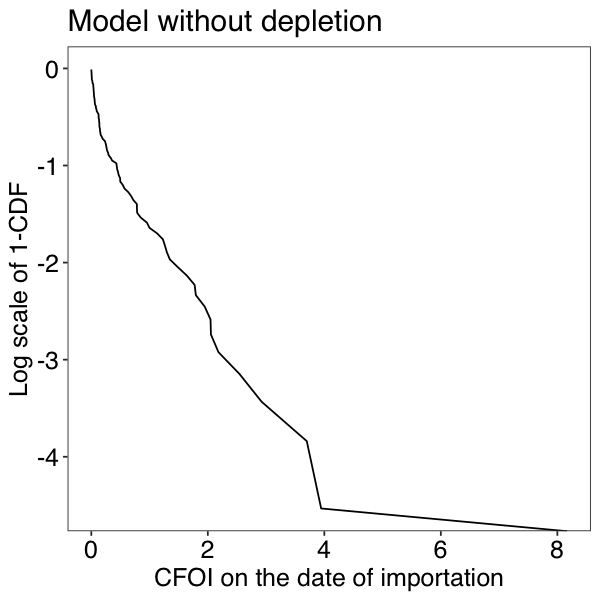

In [29]:
temp_round %>% mutate(prop_n=n/sum(temp_round$n)) %>% 
mutate(cum_prop_n=cumsum(prop_n), cum_prop_n2=log(1-cum_prop_n), log_x=log(cum_h_i)) -> temp_figure

options(repr.plot.width=5,repr.plot.height=5)
temp_figure %>%
ggplot(aes(x=cum_h_i, y=cum_prop_n2)) +
geom_line() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
     plot.title = element_text(size=18, family="sans",color="black")) +  
scale_y_continuous(limits=c(-4.54, 0)) + 
ggtitle("Model without depletion") + 
labs(x="CFOI on the date of importation", y="Log scale of 1-CDF") -> fig_wo
fig_wo
saveRDS(fig_wo, "fig_wo.rds")

In [45]:
temp_round %>% mutate(prop_n=n/sum(temp_round$n)) %>% 
mutate(cum_prop_n=cumsum(prop_n), cum_prop_n2=log(1-cum_prop_n), 
       log_x=log(cum_h_i), log_x2=log(1+cum_h_i)) -> temp_figure

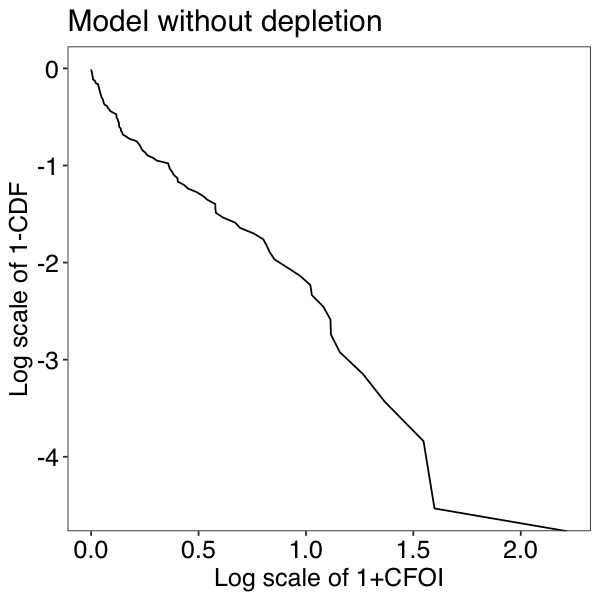

In [46]:
options(repr.plot.width=5,repr.plot.height=5)
temp_figure %>%
ggplot(aes(x=log_x2, y=cum_prop_n2)) +
geom_line() +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
      axis.title = element_text(size=15, family="sans",color="black"),
      axis.text = element_text(size=15, family="sans",color="black"),
     plot.title = element_text(size=18, family="sans",color="black")) +  
scale_y_continuous(limits=c(-4.54, 0)) + 
ggtitle("Model without depletion") + 
labs(x="Log scale of 1+CFOI", y="Log scale of 1-CDF")

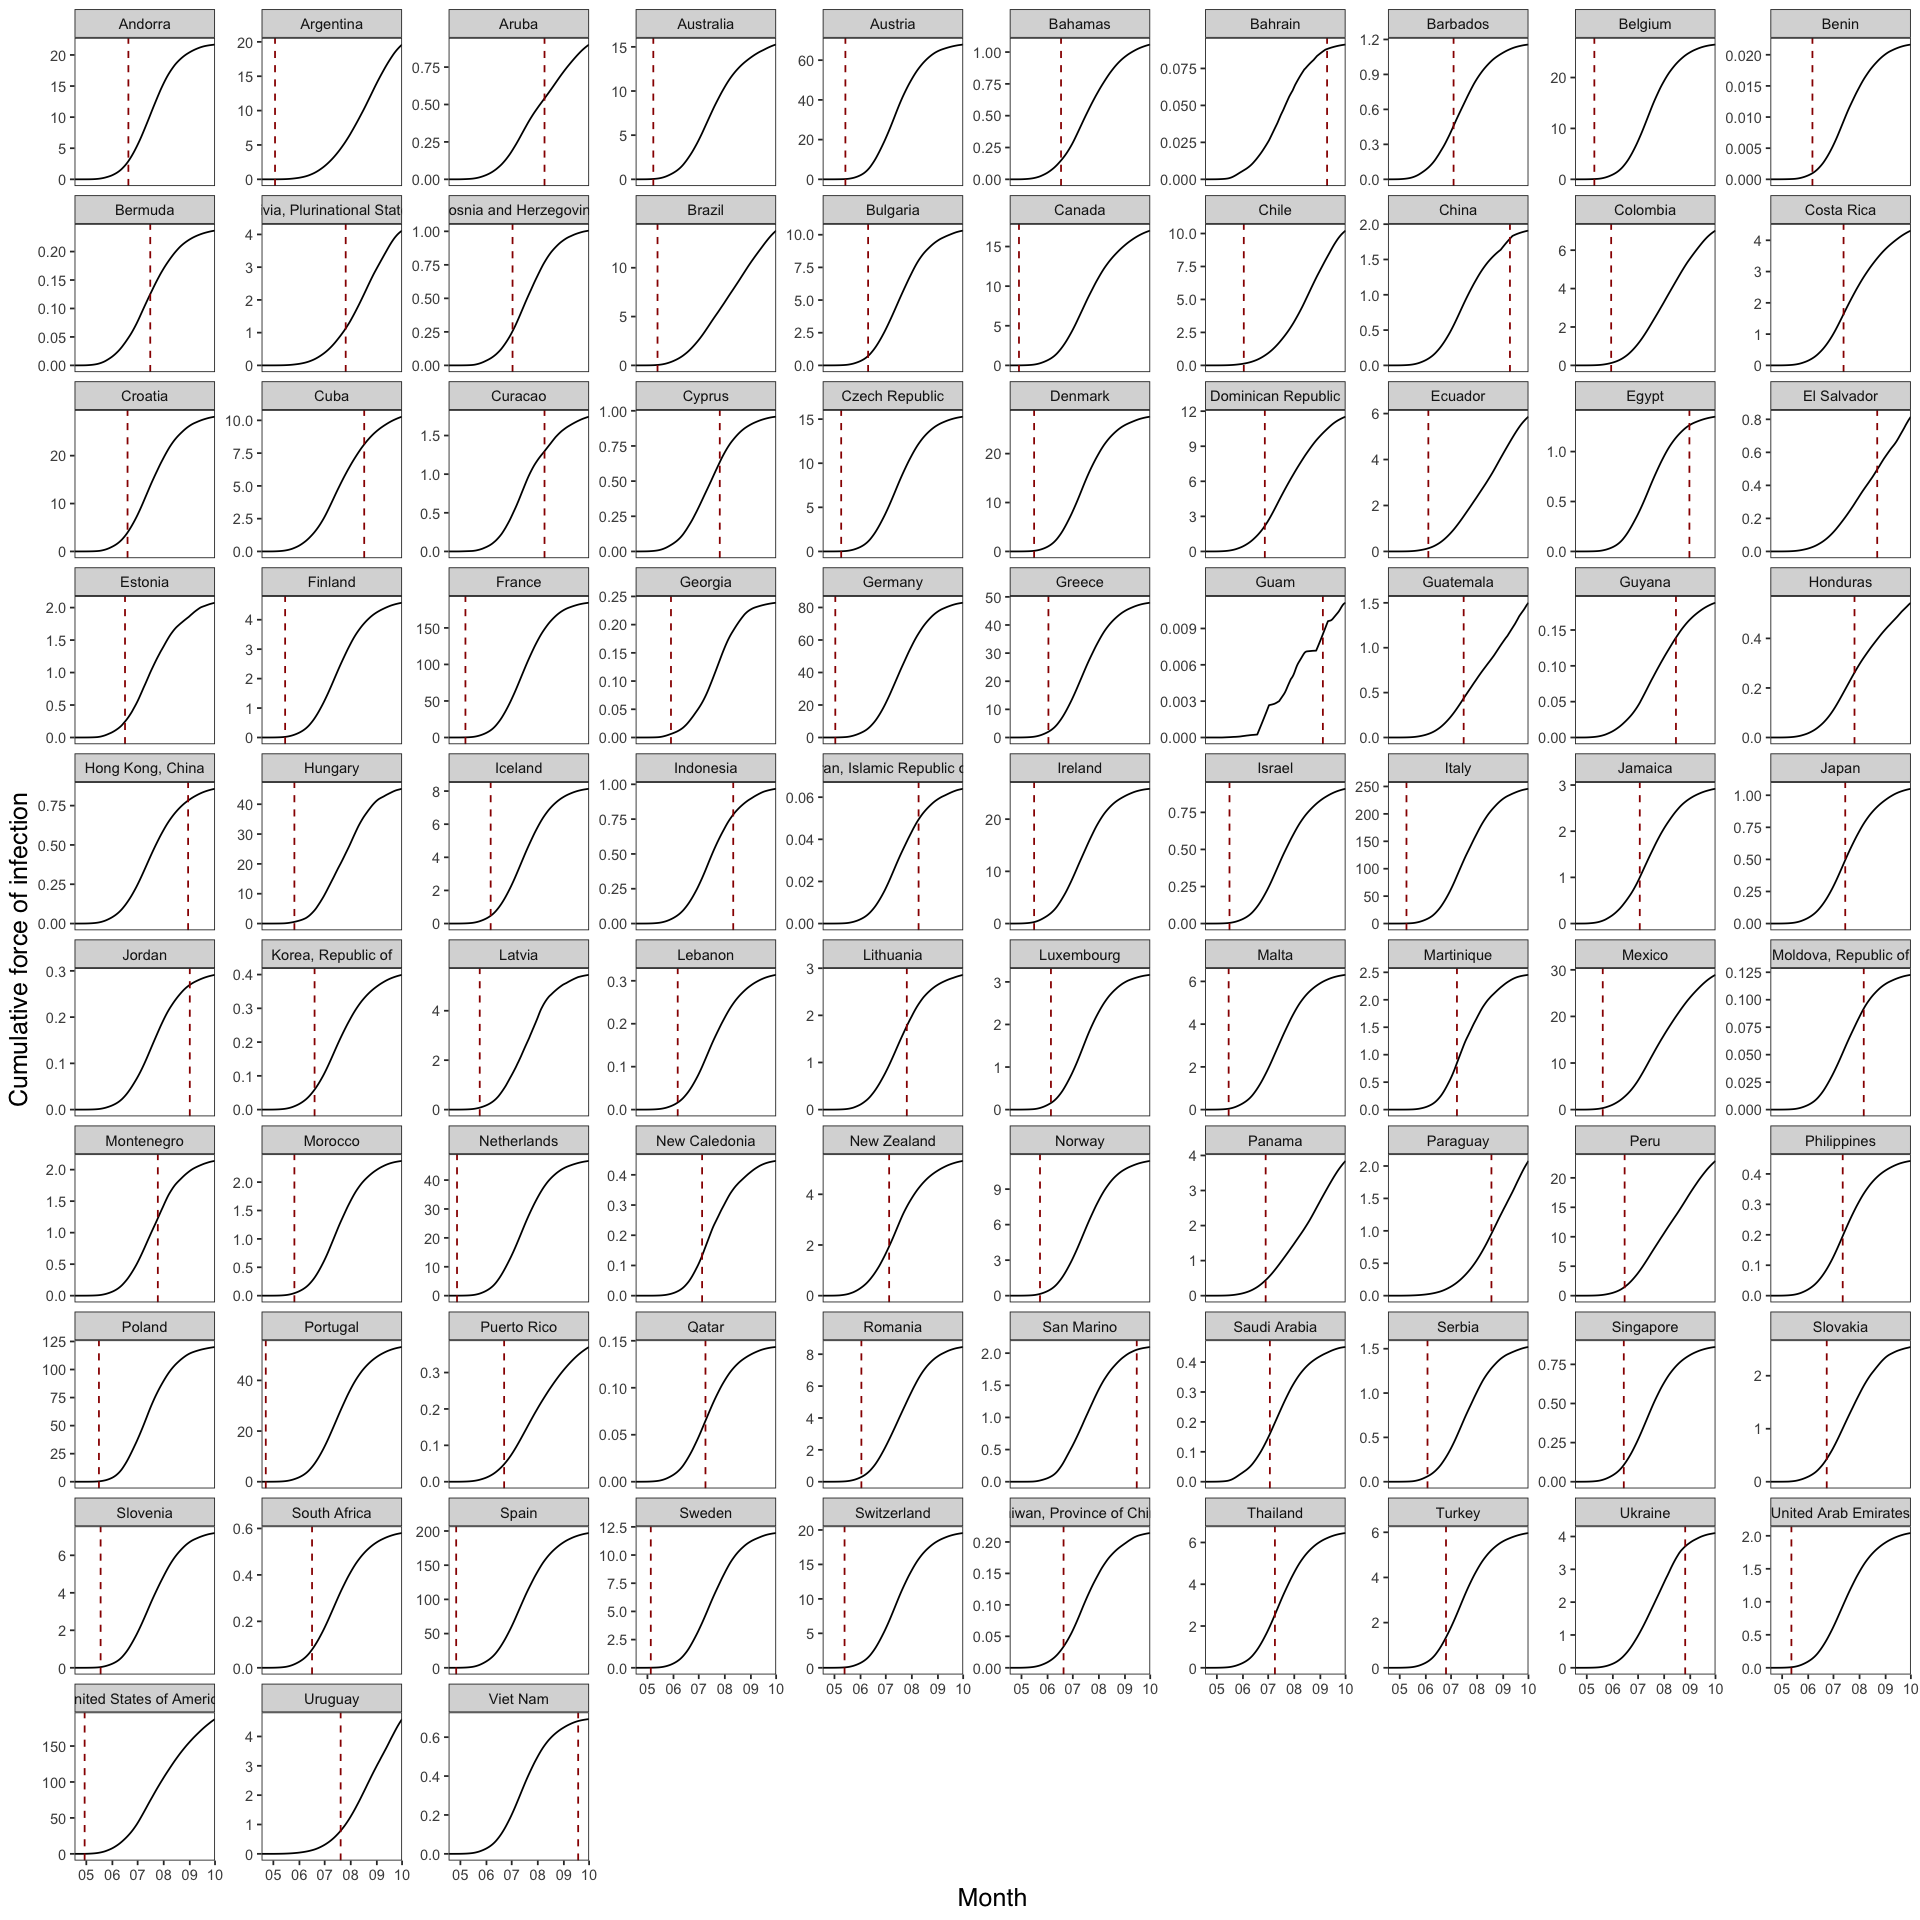

In [12]:
options(repr.plot.width=16,repr.plot.height=16)

cum_global_FoI_data %>%
ggplot(aes(x = date, y = cum_h_i)) + 
geom_line() +
geom_vline(data=df_import, aes(xintercept=import), linetype="dashed", color="#990000") +
# geom_hline(data=df_import, aes(yintercept=cutoff), linetype="dashed", color = "#1380A1") +
theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
       axis.title = element_text(size=15, family="sans",color="black")) + 
scale_x_date(date_breaks = "1 months", date_labels="%m", expand = c(0, 0)) +
labs(x="Month", y="Cumulative force of infection") +
facet_wrap(~location, scales = "free_y")

ggsave("cum_FoI_counter.png", width = 16, height = 16)